# $Final \space project \space PDE's \space course$

Primeramente pensamos el problema como uno de autovalores, entonces calculamos el espectro del Hamiltoniano.

In [1]:
import Pkg; Pkg.activate("./gridap_makie"); # activamos el proyecto "gridap_makie" donde se intalarán todos los paquetes

install_packages=false;
if install_packages
    import Pkg
    Pkg.add("GridapGmsh");
    Pkg.add("Gmsh");
    Pkg.add("FileIO");
end

using Gridap;
using GridapGmsh;
using Gmsh;

using Plots;

# crear directorios en caso de no haberlo hecho
create_directories = false;
if (create_directories==true)
    mkdir("models");
    mkdir("images");
end

using FileIO;

# en caso de querer plotear dentro de Jupiter Notebook
#  debemos usar algunos paquetes. (no funciona en VSCode)
plot_s = false;
if plot_s
    using GridapMakie, GLMakie; #Para graficar 
    using FileIO;               #Gráficos y salidas
end

  Activating project at `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie`


### Cargamos paquetes específicos para Algebra Lineal

In [166]:
install_packages=false;
if install_packages
    import Pkg
    Pkg.add("LinearAlgebra");
    Pkg.add("SparseArrays");
    Pkg.add("LinearAlgebra");
    Pkg.add("Arpack");
end
using LinearAlgebra;
using SparseArrays;
using SuiteSparse;
using Arpack;

### Incluimos módulo de funciones para resolver problema de autovalores

In [167]:
include("eigen.jl");

In [168]:
n₁=50;dom₁=(0,1,0,1);                             # cantidad de FE y dominio espacial
partition₁ = (n,n);                              # grilla de tamaño n²
model₁ = CartesianDiscreteModel(dom₁,partition₁);  # creamos modelo con elementos cartesianos
writevtk(model₁,"./images/BO_aprox");                     # escribimos el modelo para visualizar con Visit

### Definimos condiciones de contorno

In [169]:
BCtype="fulldirichlet";
if BCtype=="fulldirichlet"
    println("BCtype = ", BCtype);
    # modified
    labels₁ = get_face_labeling(model₁);
    add_tag_from_tags!(labels₁,"D1",[1,7,3,2,4,8]);   # lineas laterales + 4 puntos vértice
    add_tag_from_tags!(labels₁,"D2",[5,6]);           # lineas superior e inferior
    dirichlet_values₁ = [0.0,0.0]; # 0.0+im*0.0
end

BCtype = fulldirichlet


2-element Vector{Float64}:
 0.0
 0.0

### Creamos triangulación de la región de integración y del borde

In [170]:
Ω₁ = Triangulation(model₁);degree₁ = 3;dΩ₁ = Measure(Ω₁,degree₁);
Γ₁ = BoundaryTriangulation(model₁,tags₁=["D1","D2"]);dΓ₁ = Measure(Γ₁,degree₁);

### Creamos espacio de referencia para los elementos finitos

In [171]:
order = 2;reffe = ReferenceFE(lagrangian,Float64,order);

### Definimos espacio de pruebas y espacio de solución

In [172]:
V₁ = TestFESpace(model,reffe;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags = ["D1","D2"]);
U₁ = TrialFESpace(V₁,dirichlet_values);

### Queremos resolver el siguiente problema de autovalores:

\begin{align}
    -\frac{\hbar ^{2}}{2m}\frac{\partial }{\partial x}\left(\frac{\partial }{\partial x}\right) u_{12} +\left(\frac{1}{2} m\omega ^{2}x^{2}+\gamma\right) u_{12} =\lambda u_{12} \\
    
    \begin{cases}
        p( x) =\frac{\hbar ^{2}}{2m}\\
        q( x) =\left ( \frac{1}{2} m\omega ^{2}x^{2}+\gamma \right )\\
        r( x) =1
    \end{cases}
    \Rightarrow \left[ -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q( x)\right] u_{12}( x) =\lambda r( x) u_{12}( x)
\end{align}

donde $u_{12}=(u_{1}+u_{2})$.

### Definimos funciones

In [173]:
m=1.0;ω=1.0;ħ=1.0;γ=0.1;x₁=0.0;x₂=2.0;
p(x) = 0.5*(ħ*ħ)*(1.0/m);
q(x) = 0.5*m*(ω*ω)*x[1]*x[1]+γ;
r(x) = 1.0;

### Definimos formas bilineales para el problema débil

+ Weak Form of the Effective Mass Schrodinger Equation
+ Reference: [https://www.physicsforums.com/threads/weak-form-of-the-effective-mass-schrodinger-equation.751282/](https://www.physicsforums.com/threads/weak-form-of-the-effective-mass-schrodinger-equation.751282/)

In [174]:
a(u,v) = ∫(p*∇(v)⋅∇(u) + q*v*u)*dΩ; # deben verificar la integración por partes
b(u,v) = ∫(r*u*v)dΩ;

### Resolvemos el problema de autovalores

In [175]:
nev = 12 # number of eigenvalues asked to evaluate.
prob = EigenProblem(a, b, U₁, V₁; nev=nev, tol=10^(-6), maxiter=100, explicittransform=:none, sigma=-1.0)
ξ, uₕs = solve(prob);

### Graficamos autovalores

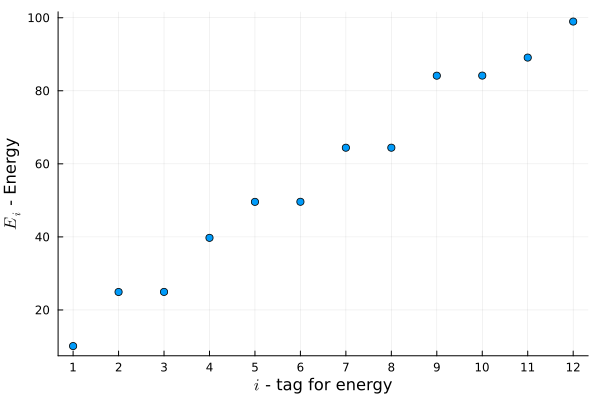

In [176]:
scatter(real(ξ),label="",xlabel="\$i\$ - tag for energy",ylabel="\$E_i\$ - Energy",xticks=(1:1:nev))

### Escribimos autovectores para visualizar con Visit

In [177]:
#=
    Gridap.CellData.get_physical_coordinate
    — Method

    get_physical_coordinate(trian::Triangulation)

    In contrast to getcellmap, the returned object:

        is a CellField
        its gradient is the identity tensor
=#
uₕsx=get_physical_coordinate(Ω);

[https://arxiv.org/pdf/1910.01412v2.pdf](https://arxiv.org/pdf/1910.01412v2.pdf)

In [178]:
function u₁(x,u₁₂)
    value1=x*0.5;
    return value1⋅u₁₂
end

u₁ (generic function with 1 method)

In [179]:
for i in 1:nev
    uₕ = uₕs[i]; # autovector asociado al autovalor 6
    writevtk(Ω,"images/eigenprob_01_num$(i)",cellfields=["uh_real" => real(uₕ), "uh_imag" => real(uₕ)]);
end

<!-- useful links: https://developer.mozilla.org/en-US/docs/Web/HTML/Element/video -->
<!-- https://www.freeconvert.com/mpeg-to-mp4 -->

### Mostramos salida de Autofunciones con visualizador Visit
<video controls width="500">
  <source src="./images/movie.mp4" type="video/mp4"/>
</video>

### Ahora queremos resolver la dinámica del problema

In [180]:
using Gridap.Arrays
using Gridap.ReferenceFEs
using Gridap.Algebra
using SparseArrays
using Gridap.FESpaces
using Gridap.CellData

In [181]:
save_file::String = "./images/";

In [182]:
particle = true;
if particle
    save_file = save_file * "particle"
    T=5;            # final time for test
    num_steps=2000; # number of time steps   
    n_int=100;      # Intervals where data is saved
end

100

In [183]:
dt=T/(num_steps-1) # time step
println("dt/dx²=$(dt*l^2) dt/dx=$(dt*l) dt³/dx⁶=$((dt*l^2)^3)")

dt/dx²=16.008004002001 dt/dx=0.2001000500250125 dt³/dx⁶=4102.150149123844


In [184]:
norm_L2(u) = sqrt(real(sum(∫(u'*u) * dΩ)));

In [185]:
function u_0_particle(x, par)
    r0,xi,k,p=par
    r=sqrt((x[1]-xi[1])^2+(x[2]-xi[2])^2)
    kx=2π*(k[1]*(x[1]-xi[1])+k[2]*(x[2]-xi[2]))
    if (r<r0)
        return (r-r0)^p * (r-r0)^p * (4^(2p)) * exp(im*kx)
    else
        return 0.0 + 0.0*im
    end
end

if particle
    par_particle = (0.4, [0.25; 0.25], [-16; 16], 4)
    u_0_particle([0.5;0.5], par_particle)
    u_0(x) = u_0_particle(x, par_particle)
end

u_0 (generic function with 1 method)

In [193]:
# u_n = interpolate_everywhere(u_0,V₁)
u_n = interpolate_everywhere(uₕs[1],V₁)
writevtk(Ω,"./images/ini_dat_$(lpad(0,3,'0'))", cellfields=["uh_r"=>real(u_n),"uh_i"=>imag(u_n)])
norm_L2(u_n)

1.0

In [197]:
m=1.0;ω=1.0;ħ=1.0;γ=0.1;x₁=0.0;x₂=2.0;
p(x) = -0.5*(ħ*ħ)*(1.0/m);
q(x) = 0.5*m*(ω*ω)*x[1]*x[1]+γ;

In [198]:
assem=SparseMatrixAssembler(U₁,V₁);           # ensamblamos una matriz sparse con U y V
dv=get_fe_basis(V₁);                         # escribimos v en la base de FE de V            
du=get_trial_fe_basis(U₁);                   # escribimos u en la base de FE de U
a₂(u,v)=∫((p*∇(v)⋅∇(u)+q*v*u)dt+im*2.0*v*u)dΩ;       # definimos forma bilineal

In [199]:
mat_contribs=a₂(du,dv);                      # creamos una matriz de bases (contribuciones)
data=collect_cell_matrix(U₁,V₁,mat_contribs); # recolectamos una matriz (datos)
A=assemble_matrix(assem,data);              # creamos matriz A con contribuciones y datos

In [200]:
t=0;  # inicializamos variable tiempo
u_n=interpolate_everywhere(u_0,V₁)
writevtk(Ω, save_file * "_$(lpad(0,3,'0'))",cellfields=["uh_r" => real(u_n), "uh_i" => imag(u_n)])

for istep in 1:num_steps

  #println("\n+++ Solving in step $istep of $num_steps +++\n")
  b₂(v)=∫((∇(v)⋅∇(-u_n)+q*v*(-u_n))*dt+im*2*v*u_n)dΩ
  vec_contribs = b₂(dv)
  data = collect_cell_vector(V₁,vec_contribs)
  b₂ = assemble_vector(assem, data)

  x = A \ b₂
  t = t + dt
  uh = FEFunction(U₁, x)

  u_n = uh

  if (istep - 1) % n_int == 0 && istep > 1
    writevtk(Ω, save_file * "_$(lpad(istep,3,'0'))",cellfields=["uh_r" => real(u_n), "uh_i" => imag(u_n)])
  end

end

### Mostramos salida de Densidad de probabilidad con visualizador Visit
<video controls width="500">
  <source src="./images/movie_density.mp4" type="video/mp4"/>
</video>